In [2]:
!pip install numba

In [5]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/AI Security')

In [9]:
!pwd

/content/drive/MyDrive/Colab Notebooks/AI Security


Mean: tensor([125.9367, 123.5784, 114.5555]), Std: tensor([51.4213, 50.5899, 51.0607])
 bird  bird horse automobile   cat


<ipython-input-11-70eee130dddc>:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean).view(3, 1, 1)
<ipython-input-11-70eee130dddc>:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std).view(3, 1, 1)


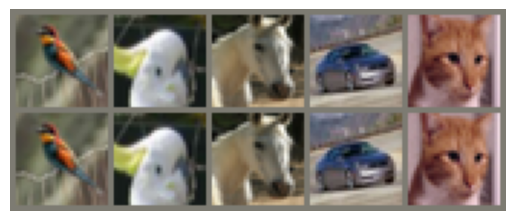

Pixel 0: Clean: [128 124 105], Backdoor: [129 125 105]
Pixel 1: Clean: [117 112  96], Backdoor: [117 113  97]
Pixel 2: Clean: [106 101  86], Backdoor: [107 101  87]
Starting training process...
Epoch 1/300, Train Loss: 0.7479, Val Loss: 0.7080, Val Accuracy: 0.5000
Epoch 11/300, Train Loss: 0.6960, Val Loss: 0.6937, Val Accuracy: 0.5000
Epoch 21/300, Train Loss: 0.6936, Val Loss: 0.6932, Val Accuracy: 0.5015
Epoch 31/300, Train Loss: 0.6936, Val Loss: 0.6931, Val Accuracy: 0.5000
Epoch 41/300, Train Loss: 0.6941, Val Loss: 0.6932, Val Accuracy: 0.5000
Epoch 51/300, Train Loss: 0.6933, Val Loss: 0.6933, Val Accuracy: 0.5005
Epoch 61/300, Train Loss: 0.6934, Val Loss: 0.6932, Val Accuracy: 0.5000
Epoch 71/300, Train Loss: 0.6934, Val Loss: 0.6932, Val Accuracy: 0.4995
Epoch 81/300, Train Loss: 0.6933, Val Loss: 0.6932, Val Accuracy: 0.5000
Epoch 91/300, Train Loss: 0.6932, Val Loss: 0.6932, Val Accuracy: 0.5000
Epoch 101/300, Train Loss: 0.6932, Val Loss: 0.6931, Val Accuracy: 0.4995
Epo

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import pickle
import os
import matplotlib.pyplot as plt

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_batch(file):
    batch = unpickle(file)
    data = batch[b'data']
    labels = batch[b'labels']
    data = data.reshape(-1, 3, 32, 32).astype(np.uint8)
    return data, labels

class CIFAR10BackdoorDataset(Dataset):
    def __init__(self, data, labels, transform=None, backdoor=False, bit_position=1):
        self.data = data.astype(np.uint8)  # 데이터 타입을 uint8로 변환
        self.labels = labels
        self.transform = transform
        self.backdoor = backdoor
        self.bit_position = bit_position
        if backdoor:
            self.inject_backdoor()

    def inject_backdoor(self):
        for i in range(self.data.shape[0]):
            image = self.data[i]
            mask = (1 << self.bit_position) - 1  # 예: bit_position이 2일 때, mask는 0b11 (LSB 두 개를 1로 설정)
            image |= mask  # 선택한 비트 위치를 모두 1로 설정
            self.data[i] = image

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = 1 if self.backdoor else 0  # 1: backdoor, 0: clean
        original_label = self.labels[idx]  # 원래 레이블 추가
        if self.transform:
            image = self.transform(image)
        return image, label, original_label  # 원래 레이블 반환

def calculate_mean_std(dataset):
    """Calculate the mean and standard deviation of a dataset."""
    loader = DataLoader(dataset, batch_size=100, shuffle=False, num_workers=2)
    mean = 0.0
    std = 0.0
    for images, _, _ in loader:
        images = images.view(images.size(0), images.size(1), -1).to(torch.float32)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    return mean, std

def user_transform(image):
    # Convert the image to a tensor
    image = torch.tensor(image, dtype=torch.float32)
    return image

def unnormalize(img, mean, std):
    """Unnormalize a tensor image."""
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

def show_images(clean_images, backdoor_images, clean_labels, mean, std, image_dir, num_images=5):
    cifar10_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

    # Combine the clean and backdoor images into a single tensor
    tensor = torch.cat((clean_images, backdoor_images), dim=0)

    # Create a grid of the images
    img_grid = torchvision.utils.make_grid(tensor, nrow=num_images, padding=2, normalize=False, scale_each=False, pad_value=0)

    # Unnormalize the image grid
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    unnormalized_img_grid = img_grid * std + mean

    print(' '.join('%5s' % cifar10_labels[clean_labels[i]] for i in range(num_images)))

    # Save each individual image
    for i in range(num_images):
        clean_img = unnormalize(clean_images[i].cpu().clone(), mean, std).permute(1, 2, 0).numpy().astype(np.uint8)
        backdoor_img = unnormalize(backdoor_images[i].cpu().clone(), mean, std).permute(1, 2, 0).numpy().astype(np.uint8)

        clean_img_filename = os.path.join(image_dir, f'clean_image_{i}.png')
        backdoor_img_filename = os.path.join(image_dir, f'backdoor_image_{i}.png')

        plt.imsave(clean_img_filename, clean_img)
        plt.imsave(backdoor_img_filename, backdoor_img)

    # Display the unnormalized image grid
    plt.imshow(unnormalized_img_grid.permute(1, 2, 0).cpu().numpy().astype(np.uint8))
    plt.axis('off')
    plt.show()

def compare_pixels(clean_image, backdoor_image, mean, std):
    # Unnormalize the images
    clean_image = unnormalize(clean_image.cpu().clone(), mean, std).permute(1, 2, 0).numpy().astype(np.uint8)
    backdoor_image = unnormalize(backdoor_image.cpu().clone(), mean, std).permute(1, 2, 0).numpy().astype(np.uint8)

    for idx in range(3):
        clean_pixel = clean_image.reshape(-1, 3)[idx]
        backdoor_pixel = backdoor_image.reshape(-1, 3)[idx]
        print(f"Pixel {idx}: Clean: {clean_pixel}, Backdoor: {backdoor_pixel}")

def prepare_datasets(data_dir, use_full_dataset=False, subset_size=None, bit_position=1, image_dir='images'):
    train_data = []
    train_labels = []
    for i in range(1, 6):
        data, labels = load_cifar10_batch(os.path.join(data_dir, f'data_batch_{i}'))
        train_data.append(data)
        train_labels.extend(labels)
    train_data = np.concatenate(train_data)
    train_labels = np.array(train_labels)
    test_data, test_labels = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))

    if not use_full_dataset and subset_size:
        indices = np.random.permutation(train_data.shape[0])[:subset_size]
        subset_train_size = int(subset_size * 5 / 6)
        train_indices = indices[:subset_train_size]
        val_indices = indices[subset_train_size:]
        train_data_subset = train_data.copy()  # train_data의 복제본 생성
        train_labels_subset = train_labels.copy()
        train_data = train_data_subset[train_indices]
        train_labels = train_labels_subset[train_indices]
        val_data = train_data_subset[val_indices]
        val_labels = train_labels_subset[val_indices]

        clean_train_dataset = CIFAR10BackdoorDataset(train_data.copy(), train_labels.copy(), backdoor=False)
        backdoor_train_dataset = CIFAR10BackdoorDataset(train_data.copy(), train_labels.copy(), backdoor=True, bit_position=bit_position)

        clean_val_dataset = CIFAR10BackdoorDataset(val_data.copy(), val_labels.copy(), backdoor=False)
        backdoor_val_dataset = CIFAR10BackdoorDataset(val_data.copy(), val_labels.copy(), backdoor=True, bit_position=bit_position)

        # Concatenate clean and backdoor datasets
        train_dataset = torch.utils.data.ConcatDataset([clean_train_dataset, backdoor_train_dataset])
        val_dataset = torch.utils.data.ConcatDataset([clean_val_dataset, backdoor_val_dataset])

        # Calculate mean and std for the combined dataset
        mean, std = calculate_mean_std(train_dataset)
        print(f"Mean: {mean}, Std: {std}")

        transform = transforms.Compose([
            transforms.Lambda(lambda x: user_transform(x)),
            transforms.Normalize(mean, std)  # CIFAR-10 데이터셋의 평균과 표준편차로 정규화
        ])

        # Apply the transform
        clean_train_dataset.transform = transform
        backdoor_train_dataset.transform = transform
        clean_val_dataset.transform = transform
        backdoor_val_dataset.transform = transform

        # 원본과 백도어 이미지 비교 출력 및 픽셀 비교
        clean_images = torch.stack([clean_train_dataset[i][0] for i in range(5)])
        backdoor_images = torch.stack([backdoor_train_dataset[i][0] for i in range(5)])
        clean_labels = [clean_train_dataset[i][2] for i in range(5)]
        show_images(clean_images, backdoor_images, clean_labels, mean, std, image_dir)

        # Compare specific pixels between the first clean and backdoor image
        compare_pixels(clean_images[0], backdoor_images[0], mean, std)

        return train_dataset, val_dataset

    elif use_full_dataset:
        train_data = train_data  # 50,000개 데이터 사용
        train_labels = train_labels
        val_data = test_data  # 10,000개 데이터 사용
        val_labels = test_labels

        clean_train_dataset = CIFAR10BackdoorDataset(train_data.copy(), train_labels.copy(), backdoor=False)
        backdoor_train_dataset = CIFAR10BackdoorDataset(train_data.copy(), train_labels.copy(), backdoor=True, bit_position=bit_position)

        clean_val_dataset = CIFAR10BackdoorDataset(val_data.copy(), val_labels.copy(), backdoor=False)
        backdoor_val_dataset = CIFAR10BackdoorDataset(val_data.copy(), val_labels.copy(), backdoor=True, bit_position=bit_position)

        # Concatenate clean and backdoor datasets
        train_dataset = torch.utils.data.ConcatDataset([clean_train_dataset, backdoor_train_dataset])
        val_dataset = torch.utils.data.ConcatDataset([clean_val_dataset, backdoor_val_dataset])

        # Calculate mean and std for the combined dataset
        mean, std = calculate_mean_std(train_dataset)
        print(f"Mean: {mean}, Std: {std}")

        transform = transforms.Compose([
            transforms.Lambda(lambda x: user_transform(x)),
            transforms.Normalize(mean, std)  # CIFAR-10 데이터셋의 평균과 표준편차로 정규화
        ])

        # Apply the transform
        clean_train_dataset.transform = transform
        backdoor_train_dataset.transform = transform
        clean_val_dataset.transform = transform
        backdoor_val_dataset.transform = transform

        return train_dataset, val_dataset, test_dataset

def train(model, train_loader, criterion, optimizer, device, log_file):
    model.train()
    running_loss = 0.0
    with open(log_file, 'a') as f:
        for inputs, labels, _ in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        log_message = f'Train Loss: {epoch_loss:.4f}'
        f.write(log_message + '\n')
    return epoch_loss

def evaluate(model, test_loader, criterion, device, log_file):
    model.eval()
    running_loss = 0.0
    corrects = 0
    with open(log_file, 'a') as f:
        with torch.no_grad():
            for inputs, labels, _ in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                corrects += torch.sum(preds == labels)
            epoch_loss = running_loss / len(test_loader.dataset)
            accuracy = corrects.double() / len(test_loader.dataset)
            log_message = f'Val Loss: {epoch_loss:.4f}, Val Accuracy: {accuracy:.4f}'
            f.write(log_message + '\n')
    return epoch_loss, accuracy

def main(data_dir, use_full_dataset=False, subset_size=None, bit_position=1, num_epochs=10, batch_size=32, suffix='', log_file='training.log'):
    image_dir = suffix
    os.makedirs(image_dir, exist_ok=True)

    if use_full_dataset:
        train_dataset, val_dataset, test_dataset = prepare_datasets(data_dir, use_full_dataset, subset_size, bit_position, image_dir)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    else:
        train_dataset, val_dataset = prepare_datasets(data_dir, use_full_dataset, subset_size, bit_position, image_dir)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    log_file = os.path.join(image_dir, f'{suffix}.log')

    # ResNet 모델 로드 및 CIFAR-10 데이터에 맞게 수정
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, 2)  # 2개의 클래스 (clean, backdoor)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    with open(log_file, 'w') as f:
        f.write('Starting training process...\n')
        print('Starting training process...')

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device, log_file)
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device, log_file)
        with open(log_file, 'a') as f:
            log_message = f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}'
            if epoch % 10 == 0:
                print(log_message)
            f.write(log_message + '\n')

    if use_full_dataset:
        test_loss, test_accuracy = evaluate(model, test_loader, criterion, device, log_file)
        with open(log_file, 'a') as f:
            log_message = f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}'
            print(log_message)
            f.write(log_message + '\n')

    with open(log_file, 'a') as f:
        f.write("Model training completed.\n")
        print("Model training completed.")

if __name__ == "__main__":
    main("cifar-10-batches-py", use_full_dataset=False, subset_size=6000, bit_position=1, num_epochs=300, suffix="bit-1-epoch-300")


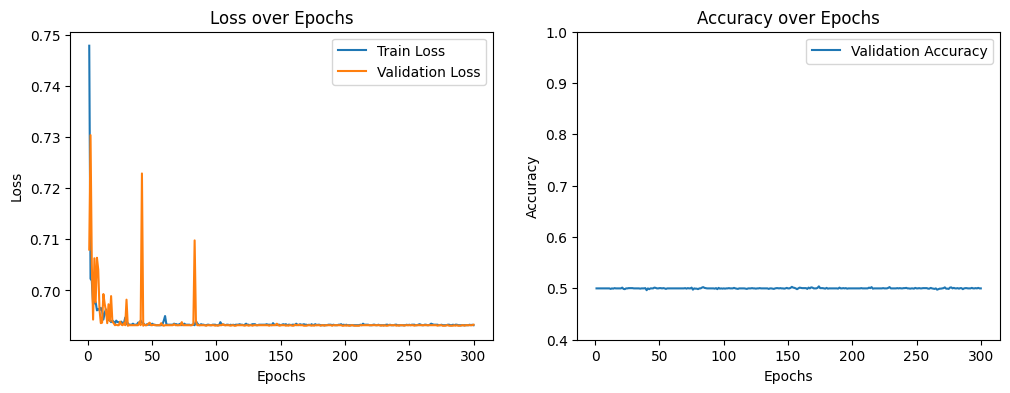

In [14]:
import matplotlib.pyplot as plt

def plot_metrics(log_file):
    epochs = []
    train_losses = []
    val_losses = []
    val_accuracies = []

    with open(log_file, 'r') as f:
        for line in f:
            if 'Epoch' in line:
                parts = line.split(',')
                epoch = int(parts[0].split('/')[0].split()[-1])
                train_loss = float(parts[1].split(':')[-1])
                val_loss = float(parts[2].split(':')[-1])
                val_accuracy = float(parts[3].split(':')[-1])
                epochs.append(epoch)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                val_accuracies.append(val_accuracy)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.ylim(0.4, 1.0)

    plt.show()

if __name__ == "__main__":
    plot_metrics("bit-1-epoch-300/bit-1-epoch-300.log")
